In [7]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import PorterStemmer as Stemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import string

In [2]:
!pip install nltk


In [9]:
nltk.download('stopwords')

# Charger les données
file_path = "final_dataset1.csv"  # Remplacez par le chemin de votre fichier
df = pd.read_csv(file_path)
df = df[['cleaned_content', 'sentiment']]

# Renommer les colonnes pour simplifier l'utilisation
df.columns = ['review', 'sentiment']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Description du dataset
print("Aperçu des données :")
print(df.head())


Aperçu des données :
                                              review sentiment
0  le revêtement céramique pour voiture été une e...  negative
1  cest facile à assembler décemment robuste pour...  positive
2                               fonctionne très bien  positive
3  lowa barcha l brosse w lutilisation mteha sehl...  positive
4                            produit fonctionne bien  positive


In [12]:
print(f"Dimensions du dataset : {df.shape}")
print("Répartition des sentiments :")
print(df['sentiment'].value_counts())


Dimensions du dataset : (1425, 2)
Répartition des sentiments :
sentiment
positive    923
negative    384
neutral     118
Name: count, dtype: int64


In [13]:
print("Informations sur le dataset :")
print(df.info())


Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1425 non-null   object
 1   sentiment  1425 non-null   object
dtypes: object(2)
memory usage: 22.4+ KB
None


In [14]:
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Valeurs manquantes par colonne :
review       0
sentiment    0
dtype: int64


In [30]:
# Fonction de nettoyage et de normalisation
def process(text):
    """Nettoie et normalise le texte."""
    text = text.lower()  # Convertir en minuscules
    text = ''.join([t for t in text if t not in string.punctuation])  # Supprimer la ponctuation
    text = [t for t in text.split() if t not in stopwords.words('french')]  # Supprimer les mots vides
    st = Stemmer()
    text = [st.stem(t) for t in text]  # Appliquer le stemming
    return ' '.join(text)

# Appliquer le nettoyage au dataset
df['processed_review'] = df['review'].apply(process)

In [16]:
# TfidfVectorizer pour transformer les avis en vecteurs
tfidfv = TfidfVectorizer(analyzer=process)
data = tfidfv.fit_transform(df['processed_review'])

In [17]:
# Exemple d'avis et transformation TF-IDF
mess = df.iloc[2]['review']
print(mess)
print(tfidfv.transform([mess]))

fonctionne très bien
  (0, 34)	0.2785242332056367
  (0, 24)	0.30266146925589965
  (0, 22)	0.1460546914355228
  (0, 19)	0.3256400508720124
  (0, 18)	0.6560161780519471
  (0, 13)	0.2865872571622245
  (0, 10)	0.1922410784322829
  (0, 9)	0.15252126765743262
  (0, 7)	0.16460019079884744
  (0, 6)	0.18872946700413282
  (0, 0)	0.26081791586823583


In [18]:
# Visualiser les scores TF-IDF
j = tfidfv.transform([mess]).toarray()[0]
print('index\tidf\ttfidf\tterm')
for i in range(len(j)):
    if j[i] != 0:
        print(i, format(tfidfv.idf_[i], '.4f'), format(j[i], '.4f'),
              tfidfv.get_feature_names_out()[i], sep='\t')

index	idf	tfidf	term
0	1.0198	0.2608	 
6	1.4759	0.1887	b
7	1.2872	0.1646	c
9	1.1928	0.1525	e
10	1.5034	0.1922	f
13	1.1206	0.2866	i
18	1.2826	0.6560	n
19	1.2733	0.3256	o
22	1.1422	0.1461	r
24	1.1834	0.3027	t
34	2.1781	0.2785	è


In [19]:
# MultinomialNB pour entraîner un classificateur bayésien naïf
sentiment_filter = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer=process)),  # Convertir les messages en vecteurs TF-IDF
    ('classifier', MultinomialNB())                    # Classificateur Bayésien Naïf
])

In [20]:
# Séparation des données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.30, random_state=21)
sentiment_filter.fit(x_train, y_train)


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function process at 0x00000227C6284670>)),
                ('classifier', MultinomialNB())])

In [21]:
# Prédictions sur les données de test
predictions = sentiment_filter.predict(x_test)
count = 0
for i in range(len(y_test)):
    if y_test.iloc[i] != predictions[i]:
        count += 1
print('Total number of test cases', len(y_test))
print('Number of wrong predictions', count)


Total number of test cases 428
Number of wrong predictions 97


In [22]:
# Calculer le Rappel, Précision et F1-Score
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

    negative       0.67      0.41      0.51       109
     neutral       1.00      0.14      0.24        29
    positive       0.79      0.97      0.87       290

    accuracy                           0.77       428
   macro avg       0.82      0.51      0.54       428
weighted avg       0.77      0.77      0.74       428



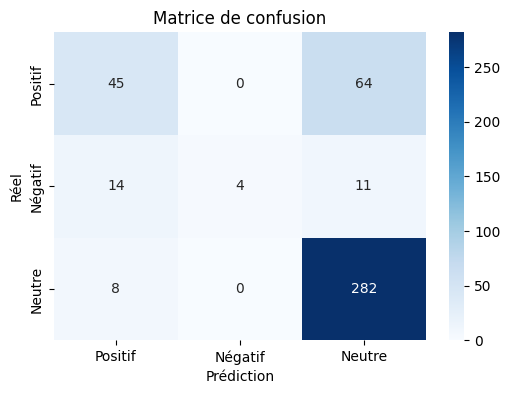

In [23]:
# Matrice de confusion
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positif', 'Négatif', 'Neutre'], yticklabels=['Positif', 'Négatif', 'Neutre'])
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()

In [24]:
# Visualisation des erreurs de classification
errors_as_positive = x_test[(predictions == 'Positif') & (y_test != 'Positif')]
errors_as_negative = x_test[(predictions == 'Négatif') & (y_test != 'Négatif')]
errors_as_neutral = x_test[(predictions == 'Neutre') & (y_test != 'Neutre')]


In [25]:
# Convertir les erreurs en DataFrame
errors_as_positive = pd.DataFrame({'Message': errors_as_positive})
errors_as_negative = pd.DataFrame({'Message': errors_as_negative})
errors_as_neutral = pd.DataFrame({'Message': errors_as_neutral})


In [26]:
# Afficher les erreurs mal classées
print("Messages mal classés comme Positif :\n", errors_as_positive)
print("Messages mal classés comme Négatif :\n", errors_as_negative)
print("Messages mal classés comme Neutre :\n", errors_as_neutral)


Messages mal classés comme Positif :
 Empty DataFrame
Columns: [Message]
Index: []
Messages mal classés comme Négatif :
 Empty DataFrame
Columns: [Message]
Index: []
Messages mal classés comme Neutre :
 Empty DataFrame
Columns: [Message]
Index: []


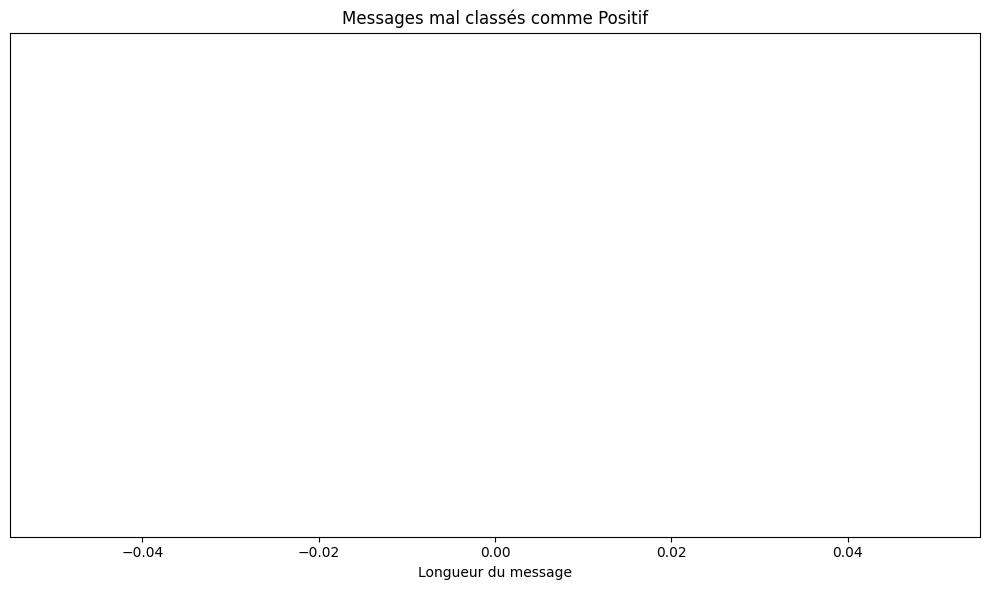

In [27]:
# Visualisation des erreurs de classification (longueur des messages)
plt.figure(figsize=(10, 6))
plt.barh(range(len(errors_as_positive)), [len(msg) for msg in errors_as_positive['Message']])
plt.yticks(range(len(errors_as_positive)), errors_as_positive['Message'], fontsize=8)
plt.xlabel("Longueur du message")
plt.title("Messages mal classés comme Positif")
plt.tight_layout()
plt.show()

In [41]:
# Prédire un avis donné
test_message = ["The service was excellent"]
result = sentiment_filter.predict(test_message)
print("L'avis est classé comme :", result[0])  # Positif, Négatif ou Neutre


L'avis est classé comme : positive


In [42]:
# Prédire un avis avec une mention spécifique
test_message2 = ["khayeb"]
result2 = sentiment_filter.predict(test_message2)
print("L'avis est classé comme :", result2[0])  # Positif, Négatif ou Neutre


L'avis est classé comme : negative
